# Derivative-free Optimisation of Neural Networks in Reinforcement Learning for Process Control: Multistage Extraction Case Study

```{attention} 
The code is based on a tutorial that can be found here: https://edgarsmdn.github.io/MLCE_book/07_RL_Control.html
```



This is the code used for developing and testing the algorithms for the report.

Import necessary modules for the code:

In [88]:
import torch
import torch.nn.functional as Ffunctional
import copy
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.lines import Line2D
from matplotlib.ticker import LinearLocator
from matplotlib.ticker import StrMethodFormatter
from pylab import grid
import time
import random
import skopt
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.plots import plot_convergence
from skopt.utils import use_named_args

The model of Multistage Extraction is coded below:

In [89]:
#@title CSTR code from tutorial 6

eps  = np.finfo(float).eps # computer computational precision

#######################
#  Distillation model #
#######################

def multistage_extraction_ode(x, t, u):
    #Based on Ingham pg 471 (449)
    #Solute and solvent extraction in 5 stage countercurrent extraction process
    #Maybe also change to include backmixing as per pg 475 (453)

    #Parameters
    Vl = 5 #Liquid volume in each stage
    Vg = 5 #Gas volume in each stage
    m = 1 #Equilibrium constant [-]
    Kla = 5 #Mass transfer capacity constant 1/hr 
    eq_exponent = 2 #Change the nonlinearity of the equilibrium relationship
    X0 = 0.6 #Feed concentration of liquid
    Y6 = 0.05 #Feed conc of gas


    ###Model Equations###

    ##States##
    #Xn - Concentration of solute in liquid pase of stage n [kg/m3]
    #Yn - Concentration of solute in gas phase of stage n [kg/m3]

    X1, Y1, X2, Y2, X3, Y3, X4, Y4, X5, Y5 = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9]

    ##Inputs##
    #L - Liquid flowrate m3/hr
    #G - Gas flowrate m3/hr

    L, G = u[0], u[1]

    X1_eq = ((Y1**eq_exponent)/m)
    X2_eq = ((Y2**eq_exponent)/m)
    X3_eq = ((Y3**eq_exponent)/m)
    X4_eq = ((Y4**eq_exponent)/m)
    X5_eq = ((Y5**eq_exponent)/m)

    Q1 = Kla*(X1 - X1_eq)*Vl
    Q2 = Kla*(X2 - X2_eq)*Vl
    Q3 = Kla*(X3 - X3_eq)*Vl
    Q4 = Kla*(X4 - X4_eq)*Vl
    Q5 = Kla*(X5 - X5_eq)*Vl

    dxdt = [
        (1/Vl)*(L * (X0 - X1) - Q1),
        (1/Vg)*(G * (Y2 - Y1) + Q1),
        (1/Vl)*(L * (X1 - X2) - Q2),
        (1/Vg)*(G * (Y3 - Y2) + Q2),
        (1/Vl)*(L * (X2 - X3) - Q3),
        (1/Vg)*(G * (Y4 - Y3) + Q3),
        (1/Vl)*(L * (X3 - X4) - Q4),
        (1/Vg)*(G * (Y5 - Y4) + Q4),
        (1/Vl)*(L * (X4 - X5) - Q5),
        (1/Vg)*(G * (Y6 - Y5) + Q5), 
        ]

    return dxdt

data_res = {} 
# Initial conditions for the states
x0             = np.zeros(10)
x0[0]          = 0.55
x0[1]          = 0.3
x0[2]          = 0.45
x0[3]          = 0.25
x0[4]          = 0.4
x0[5]          = 0.20
x0[6]          = 0.35
x0[7]          = 0.15
x0[8]          = 0.25
x0[9]          = 0.1
data_res['x0'] = x0

# Time interval (min)
n             = 101 # number of intervals
tp            = 25 # process time (min)
t             = np.linspace(0,tp,n)
data_res['t'] = t
data_res['n'] = n

# Store results for plotting
X1 = np.zeros(len(t));      X1[0]  = x0[0]
Y1  = np.zeros(len(t));     Y1[0]  = x0[1]
X2  = np.zeros(len(t));     X2[0]  = x0[2]
Y2  = np.zeros(len(t));     Y2[0]  = x0[3]
X3  = np.zeros(len(t));     X3[0]  = x0[4]
Y3  = np.zeros(len(t));     Y3[0]  = x0[5]
X4  = np.zeros(len(t));     X4[0]  = x0[6]
Y4  = np.zeros(len(t));     Y4[0]  = x0[7]
X5  = np.zeros(len(t));     X5[0]  = x0[8]
Y5  = np.zeros(len(t));     Y5[0]  = x0[9]
L = np.zeros(len(t)-1);  
G = np.zeros(len(t)-1);

data_res['X1_dat'] = copy.deepcopy(X1)
data_res['Y1_dat'] = copy.deepcopy(Y1)
data_res['X2_dat'] = copy.deepcopy(X2)
data_res['Y2_dat'] = copy.deepcopy(Y2)
data_res['X3_dat'] = copy.deepcopy(X3)
data_res['Y3_dat'] = copy.deepcopy(Y3)
data_res['X4_dat'] = copy.deepcopy(X4)
data_res['Y4_dat'] = copy.deepcopy(Y4)
data_res['X5_dat'] = copy.deepcopy(X5)
data_res['Y5_dat'] = copy.deepcopy(Y5)
data_res['L_dat']  = copy.deepcopy(L)
data_res['G_dat']  = copy.deepcopy(G)

# noise level
noise             = 0.1
data_res['noise'] = noise

# control upper and lower bounds
data_res['L_ub']  = 500
data_res['L_lb']  = 5
data_res['G_ub']  = 1000
data_res['G_lb']  = 10
L_ub              = data_res['L_ub']
L_lb              = data_res['L_lb']
G_ub              = data_res['G_ub']
G_lb              = data_res['G_lb']

# desired setpoints
n_1                = int(n/4)
n_2                = n_1
n_3                = n_1
n_4                = n - n_1 - n_2 - n_3

X5_des             = [0.3 for i in range(n_1)] + [0.4 for i in range(n_2)] + [0.4 for i in range(n_3)] + [0.3 for i in range(n_4)]
#Xf_des             = [ for i in range(n_1)] + [ for i in range(n_2)]
Y1_des             = [0.3 for i in range(n_1)] + [0.3 for i in range(n_2)] + [0.35 for i in range(n_3)] + [0.35 for i in range(n_4)]
data_res['X5_des'] = X5_des
data_res['Y1_des'] = Y1_des

##################
# PID controller #
##################

def PID(Ks, x, x_setpoint, e_history):

    Ks    = np.array(Ks)
    Ks    = Ks.reshape(7, order='C')

    # K gains
    KpX5 = Ks[0]; KiX5 = Ks[1]; KdX5 = Ks[2]
    KpY1  = Ks[3]; KiY1  = Ks[4]; KdY1  = Ks[5]; 
    Kb   = Ks[6]
    # setpoint error
    e = x_setpoint - x
    # control action
    u  = KpX5*e[0] + KiX5*sum(e_history[:,0]) + KdX5*(e[0]-e_history[-1,0])
    u += KpY1*e[1] + KiY1*sum(e_history[:,1]) + KdY1*(e[1]-e_history[-1,1])
    u += Kb
    u[0]  = min(max(u[0],data_res['L_lb']),data_res['L_ub'])
    u[1]  = min(max(u[1],data_res['F_lb']),data_res['G_ub'])

    return u

Code for creating the plots to visualise the results:

In [90]:
#@title Ploting routines

####################################
# plot control actions performance #
####################################

def plot_simulation(X5_dat, Y1_dat, L_dat, G_dat, X5_dat2, Y1_dat2, L_dat2, G_dat2, data_simulation):    # X1_dat, X2_dat, X3_dat, X4_dat, Y2_dat, Y3_dat, Y4_dat, Y5_dat,
    
    X5_des = data_simulation['X5_des']
    Y1_des = data_simulation['Y1_des']
    font_size = 8

    label1 = 'Generalised Policy Search'
    label2 = 'GPS with Bayesian Optimisation'

    cols = ['#ff7f00', '#1f78b4', '#ff7f00', '#1f78b4', '#ff7f00', '#1f78b4', '#ff7f00', '#1f78b4']
    
    plt.figure(figsize=(10, 10))

    plt.subplot(4,1,1)
    plt.plot(t, np.median(X5_dat,axis=1), '-', color=cols[0], lw=3, label=label1)
    plt.plot(t, np.median(X5_dat2,axis=1), '-', color=cols[1], lw=3, label=label2)
    plt.gca().fill_between(t, np.min(X5_dat,axis=1), np.max(X5_dat,axis=1), 
                           color=cols[0], alpha=0.2)
    plt.gca().fill_between(t, np.min(X5_dat2,axis=1), np.max(X5_dat2,axis=1),
                            color=cols[1], alpha=0.2)
    plt.step(t, X5_des, '--', lw=1.5, color='black')
    plt.ylabel('$X_5$ $(mol/mol)$')
    plt.xlabel('Time $(min)$')
    legend_title = 'Liquid phase mole fraction in fifth stage'
    legend_labels = [label1, label2]
    legend_lines = [Line2D([0], [0], color=cols[0], lw=3),
                    Line2D([0], [0], color=cols[1], lw=3)]
    plt.legend(handles=legend_lines, labels=legend_labels, title=legend_title, loc='best', title_fontsize=font_size, fontsize=font_size)
    plt.xlim(min(t), max(t))

    plt.subplot(4,1,2)
    plt.plot(t, np.median(Y1_dat,axis=1), '-', color=cols[2], lw=3, label=label1)
    plt.plot(t, np.median(Y1_dat2,axis=1), '-', color=cols[3], lw=3, label=label2)
    plt.gca().fill_between(t, np.min(Y1_dat,axis=1), np.max(Y1_dat,axis=1), 
                           color=cols[2], alpha=0.2)
    plt.gca().fill_between(t, np.min(Y1_dat2,axis=1), np.max(Y1_dat2,axis=1),
                            color=cols[3], alpha=0.2)
    plt.step(t, Y1_des, '--', lw=1.5, color='black')
    plt.ylabel('$Y_1$ $(mol/mol)$')
    plt.xlabel('Time $(min)$')
    legend_title = 'Gas phase mole fraction in first stage'
    legend_labels = [label1, label2]
    legend_lines = [Line2D([0], [0], color=cols[2], lw=3),
                    Line2D([0], [0], color=cols[3], lw=3)]
    plt.legend(handles=legend_lines, labels=legend_labels, title=legend_title, loc='best', title_fontsize=font_size, fontsize=font_size)
    plt.xlim(min(t), max(t))

    plt.subplot(4,1,3)
    plt.step(t[1:], np.median(L_dat,axis=1), '--', color=cols[4], lw=3, label=label1)
    plt.step(t[1:], np.median(L_dat2,axis=1), '--', color=cols[5], lw=3, label=label2)
    plt.ylabel('$L$ $(m^3/hr)$')
    plt.xlabel('Time $(min)$')
    legend_title = 'Liquid flowrate in system'
    legend_labels = [label1, label2]
    legend_lines = [Line2D([0], [0], color=cols[4], lw=3),
                    Line2D([0], [0], color=cols[5], lw=3)]
    plt.legend(handles=legend_lines, labels=legend_labels, title=legend_title, loc='best', title_fontsize=font_size, fontsize=font_size)
    plt.xlim(min(t), max(t))
    
    plt.subplot(4,1,4)
    plt.step(t[1:], np.median(G_dat,axis=1), '--', color=cols[6], lw=3, label=label1)
    plt.step(t[1:], np.median(G_dat2,axis=1), '--', color=cols[7], lw=3, label=label2)
    plt.ylabel('$G$ $(m^3/hr)$')
    plt.xlabel('Time $(min)$')
    legend_title = 'Gas flowrate in system'
    legend_labels = [label1, label2]
    legend_lines = [Line2D([0], [0], color=cols[6], lw=3),
                    Line2D([0], [0], color=cols[7], lw=3)]
    plt.legend(handles=legend_lines, labels=legend_labels, title=legend_title, loc='best', title_fontsize=font_size, fontsize=font_size)
    plt.xlim(min(t), max(t))


    plt.tight_layout()
    plt.show()

##################
# Training plots #
##################

def plot_training(data_simulation, repetitions):
    t        = data_simulation['t'] 
    X5_train = np.array(data_simulation['X5_train'])
    Y1_train = np.array(data_simulation['Y1_train'])
    L_train = np.array(data_simulation['L_train'])
    G_train = np.array(data_simulation['G_train'])
    X5_des   = data_simulation['X5_des']
    Y1_des    = data_simulation['Y1_des']

    c_    = [(repetitions - float(i))/repetitions for i in range(repetitions)]

    plt.figure(figsize=(8, 5))

    plt.subplot(3,1,1)
    for run_i in range(repetitions):
        plt.plot(t, X5_train[run_i,:], 'r-', lw=1, alpha=c_[run_i])
        plt.step(t, X5_des, '--', lw=1.5, color='black')
        plt.ylabel('X5 (mol/mol)')
        plt.xlabel('Time (min)')
        plt.legend(['Liquid mole fraction in fifth stage'],loc='best')
        plt.title('Training plots')
        plt.xlim(min(t), max(t))
        grid(True)

    plt.subplot(3,1,2)
    for run_i in range(repetitions):
        plt.plot(t, Y1_train[run_i,:], 'c-', lw=1, alpha=c_[run_i])
        plt.step(t, Y1_des, '--', lw=1.5, color='black')
        plt.ylabel('Y1 (mol/mol)')
        plt.xlabel('Time (min)')
        plt.legend(['Gas mole fraction in first stage'],loc='best')
        plt.xlim(min(t), max(t))
        grid(True)

    plt.subplot(3,1,3)
    for run_i in range(repetitions):
        plt.step(t[1:], L_train[run_i,:], 'b--', lw=1, alpha=c_[run_i])
        plt.ylabel('L (m3/hr)')
        plt.xlabel('Time (min)')
        plt.legend(['Liquid flowrate in system'],loc='best')
        plt.xlim(min(t), max(t))
        grid(True)
    
    
    plt.tight_layout()

    plt.show()

#####################
# Convergence plots #
#####################

def plot_convergence(Xdata, best_Y, Objfunc=None):
    '''
    Plots to evaluate the convergence of standard Bayesian optimization algorithms
    '''
    ## if f values are not given
    f_best  = 1e8
    if best_Y==None: 
        best_Y = []
        for i_point in range(Xdata.shape[0]):
            f_point = Objfunc(Xdata[i_point,:], collect_training_data=False)
            if f_point < f_best:
                f_best = f_point 
            best_Y.append(f_best)
        best_Y = np.array(best_Y)

    n = Xdata.shape[0]
    aux = (Xdata[1:n,:]-Xdata[0:n-1,:])**2
    distances = np.sqrt(aux.sum(axis=1))

    ## Distances between consecutive x's
    plt.figure(figsize=(9,3))
    plt.subplot(1, 2, 1)
    plt.plot(list(range(n-1)), distances, '-ro')
    plt.xlabel('Iteration')
    plt.ylabel('d(x[n], x[n-1])')
    plt.title('Distance between consecutive x\'s')
    plt.xlim(0, n)
    grid(True)

    # Best objective value found over iterations
    plt.subplot(1, 2, 2)
    plt.plot(list(range(n)), best_Y,'-o')
    plt.title('Value of the best selected sample')
    plt.xlabel('Iteration')
    plt.ylabel('Best y')
    grid(True)
    plt.xlim(0, n)
    plt.tight_layout()
    plt.show()

#####################
# Algorithm performance plots #
#####################

def performance_plots(iterations, time, gbest, multiruns=False):
    
    iterations = list(range(1, len(gbest)+1))  
    
    plt.figure(figsize=(8, 8))

    plt.subplot(2,1,1)
    plt.plot(iterations, gbest, 'r-')
    if multiruns == True:
        plt.plot(iterations, np.median(gbest,axis=1), 'r-')
        plt.gca().fill_between(iterations, np.min(gbest,axis=1), np.max(gbest,axis=1), 
                               color='r', alpha=0.2)
    plt.ylabel('Best reward')
    plt.xlabel('Iterations')
    plt.title('Best Reward vs Iterations')
    plt.xlim(min(iterations), max(iterations))
    plt.yscale('log')



    plt.subplot(2,1,2)
    plt.plot(time, gbest, 'b-')
    if multiruns == True:
        plt.plot(time, np.median(gbest,axis=1), 'b-')
        plt.gca().fill_between(time, np.min(gbest,axis=1), np.max(gbest,axis=1), 
                               color='b', alpha=0.2)
    plt.ylabel('Best reward')
    plt.xlabel('Time (s)')
    plt.title('Best Reward vs Time')
    plt.xlim(min(time), max(time))
    plt.yscale('log')


    plt.tight_layout()

    plt.show()




    

Neural network policy initialisation:

In [91]:
##################
# Policy Network #
##################

class Net(torch.nn.Module):
  # in current form this is a linear function (wouldn't expect great performance here)
    def __init__(self, **kwargs):
        super(Net, self).__init__()

        self.dtype    = torch.float

        # Unpack the dictionary 
        self.args     = kwargs

        # Get info of machine
        self.use_cuda = torch.cuda.is_available() 
        self.device   = torch.device("cpu")

        # Define ANN topology 
        self.input_size = self.args['input_size']
        self.output_sz  = self.args['output_size']
        self.hs1        = self.input_size*2 # *2 16
        self.hs2        = self.output_sz*2 # *2 4

        # Define layers 
        self.hidden1 = torch.nn.Linear(self.input_size, self.hs1)
        self.hidden2 = torch.nn.Linear(self.hs1, self.hs2)
        self.output  = torch.nn.Linear(self.hs2, self.output_sz)

    def forward(self, x):
        #x = torch.tensor(x.view(1,1,-1)).float() # re-shape tensor
        x = x.view(1, 1, -1).float()
        y = Ffunctional.elu(self.hidden1(x), 0.1)
        y = Ffunctional.leaky_relu(self.hidden2(y), 0.1)
        y = Ffunctional.relu6(self.output(y))   # range (0,6)

        return y

Normalisation of inputs (states and set point errors) and actions:

In [67]:
# normalization for states and actions
data_res['x_norm'] = np.array([means, ranges]) # [mean],[range]
data_res['u_norm'] = np.array([[495/6, 990/6],[5, 10]])    # [range/6],[bias]

The objective function for the policy network:


In [68]:
def J_PolicyDIST(policy, data_res=data_res, policy_alg='PID', 
                 collect_training_data=True, traj=False, episode=False):
    
    # load data
    X1    = copy.deepcopy(data_res['X1_dat'])
    Y1    = copy.deepcopy(data_res['Y1_dat'])
    X2    = copy.deepcopy(data_res['X2_dat'])
    Y2    = copy.deepcopy(data_res['Y2_dat'])
    X3    = copy.deepcopy(data_res['X3_dat'])
    Y3    = copy.deepcopy(data_res['Y3_dat'])
    X4    = copy.deepcopy(data_res['X4_dat'])
    Y4    = copy.deepcopy(data_res['Y4_dat'])
    X5    = copy.deepcopy(data_res['X5_dat'])
    Y5    = copy.deepcopy(data_res['Y5_dat'])
    L     = copy.deepcopy(data_res['L_dat'])
    G     = copy.deepcopy(data_res['G_dat'])
    t     = copy.deepcopy(data_res['t']) 
    x0    = copy.deepcopy(data_res['x0'])
    noise = data_res['noise']
    

    # setpoints      
    X5_des = data_res['X5_des']; Y1_des = data_res['Y1_des']
    
    # upper and lower bounds
    L_ub  = data_res['L_ub'];  L_lb  = data_res['L_lb']
    G_ub  = data_res['G_ub'];  G_lb  = data_res['G_lb']
    
    # normalized states and actions
    x_norm = data_res['x_norm']; u_norm = data_res['u_norm'];

    # initiate
    x         = copy.deepcopy(data_res['x0'])
    e_history = []

    # log probs
    if policy_alg == 'PG_RL':
      log_probs = [None for i in range(len(t)-1)]
    
    # Simulate column
    for i in range(len(t)-1):
        # delta t
        ts      = [t[i],t[i+1]]
        # desired setpoint
        x_sp    = np.array([X5_des[i], Y1_des[i]]) # since we only care about controlling the first and last variables, set the s.p. of the others equal to the process variable
        ctrl_x  = np.array([x[8], x[1]])
        #### PID ####
        if policy_alg == 'PID':
          if i == 0:
            Tc[i] = PID(policy, x, x_sp, np.array([[0,0]]))
          else:
            Tc[i] = PID(policy, x, x_sp, np.array(e_history))

        # --------------> New compared to tutorial 6 <-------------------
        #### Stochastic Policy Search ####
        elif policy_alg == 'SPS_RL':
          xk      = np.hstack((ctrl_x,x_sp-ctrl_x))
          # state preprocesing
          xknorm       = (xk-x_norm[0])/x_norm[1]
          xknorm_torch = torch.tensor(xknorm)
          # compute u_k from policy
          # print('normalised state',xknorm)
          mean_uk      = policy(xknorm_torch).detach().numpy()
          u_k          = np.reshape(mean_uk, (1, 2))
          u_k          = u_k*u_norm[0] + u_norm[1]
          #print("The first value for u_k is:", u_k)
          u_k          = u_k[0]
          #print("The second value for u_k is:", u_k)
          u_k[0]       = min(max(u_k[0], L_lb), L_ub)
          u_k[1]       = min(max(u_k[1], G_lb), G_ub)
          #print("The third value for u_k is:", u_k)
          L[i]         = u_k[0]
          G[i]         = u_k[1]
          eqn_inputs   = (L[i], G[i])
          
          

        #### Policy Gradients #### 
        # See next section for the explanation on Policy gradients!
        elif policy_alg == 'PG_RL':
          xk      = np.hstack((x,x_sp-x))
          # state preprocesing
          xknorm       = (xk-x_norm[0])/x_norm[1]
          xknorm_torch = Tensor(xknorm)
          # compute u_k distribution
          m, s                      = policy(xknorm_torch)[0,0]
          s                         = s + eps
          mean_uk, std_uk           = mean_std(m, s)
          u_k, logprob_k, entropy_k = select_action(mean_uk, std_uk)
          u_k                       = np.reshape(u_k.numpy(), (nu))
          # hard bounds on inputs
          u_k                       = min(max(u_k, Tc_lb), Tc_ub)
          Tc[i]                     = u_k
          log_probs[i] = logprob_k
        # ----------------------------------------------------------------

        # simulate system
        y            = odeint(multistage_extraction_ode,x,ts,args=(eqn_inputs,))
        # add process disturbance
        s            = np.random.uniform(low=-1, high=1, size=2)
        X1[i+1]      = max(min(y[-1][0] + noise*s[0]*0.1, 1), 0)   
        Y1[i+1]      = max(min(y[-1][1] + noise*s[0]*0.1, 1), 0) 
        X2[i+1]      = max(min(y[-1][2] + noise*s[0]*0.1, 1), 0) 
        Y2[i+1]      = max(min(y[-1][3] + noise*s[0]*0.1, 1), 0) 
        X3[i+1]      = max(min(y[-1][4] + noise*s[0]*0.1, 1), 0) 
        Y3[i+1]      = max(min(y[-1][5] + noise*s[0]*0.1, 1), 0) 
        X4[i+1]      = max(min(y[-1][6] + noise*s[0]*0.1, 1), 0) 
        Y4[i+1]      = max(min(y[-1][7] + noise*s[0]*0.1, 1), 0) 
        X5[i+1]      = max(min(y[-1][8] + noise*s[1]*0.1, 1), 0)
        Y5[i+1]      = max(min(y[-1][9] + noise*s[1]*0.1, 1), 0)
        # state update
        x[0]         = X1[i+1]
        x[1]         = Y1[i+1]
        x[2]         = X2[i+1]
        x[3]         = Y2[i+1]
        x[4]         = X3[i+1]
        x[5]         = Y3[i+1]
        x[6]         = X4[i+1]
        x[7]         = Y4[i+1]
        x[8]         = X5[i+1]
        x[9]         = Y5[i+1]
        # compute tracking error
        ctrl_x = np.array([x[8], x[1]])
        e_history.append((x_sp-ctrl_x))

    # == objective == #
    # tracking error
    error = np.abs(np.array(e_history)[:,0])/ranges[1]+np.abs(np.array(e_history)[:,1])/ranges[0]
    # penalize magnitude of control action
    u_mag = np.abs(L[:]-L_lb)/20+np.abs(G[:]-G_lb)/20
    u_mag = u_mag*0 # min 50
    # penalize change in control action
    u_cha = np.abs(L[1:]-L[0:-1])/20+np.abs(G[1:]-G[0:-1])/20
    u_cha = u_cha*0 # min 10 
    
    # collect data for plots
    if collect_training_data:
        data_res['X1_train'].append(X1)
        data_res['Y1_train'].append(Y1)
        data_res['X2_train'].append(X2)
        data_res['Y2_train'].append(Y2)
        data_res['X3_train'].append(X3)
        data_res['Y3_train'].append(Y3)
        data_res['X4_train'].append(X4)
        data_res['Y4_train'].append(Y4)
        data_res['X5_train'].append(X5)
        data_res['Y5_train'].append(Y5)
        data_res['L_train'].append(L)
        data_res['G_train'].append(G)
        data_res['err_train'].append(error)
        data_res['u_mag_train'].append(u_mag)
        data_res['u_cha_train'].append(u_cha)

    # sums
    error = np.sum(error)
    u_mag = np.sum(u_mag)
    u_cha = np.sum(u_cha)

    if episode:
      # See next section for the explanation on Policy gradients!
      sum_logprob = sum(log_probs)
      reward      = -(error + u_mag + u_cha)
      return reward, sum_logprob
    
    if traj:
      return X5, Y1, L, G
    else:
      return error + u_mag + u_cha # u_mag is the culprit now


Defining policy optimisation functions:

In [69]:
#######################
# auxiliary functions #
#######################

def sample_uniform_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min \
              for k, v in params_prev.items()}              
    return params

def sample_local_params(params_prev, param_max, param_min):
    params = {k: torch.rand(v.shape)* (param_max - param_min) + param_min + v \
              for k, v in params_prev.items()}              
    return params

def extract_NN_values(list_of_params):
    rows_tensors = []
    for params_dict in list_of_params:
        layer_shapes = []
        list_tensors = []
        layer_sizes = []
        for tensor in params_dict.values():
            list_tensors.append(torch.flatten(tensor))
            layer_sizes.append(torch.numel(tensor))
            layer_shapes.append(tensor.size())
        row_tensors = torch.cat(list_tensors)
        rows_tensors.append(row_tensors)
    mat_tensors = torch.stack(rows_tensors)
    return mat_tensors, layer_sizes, layer_shapes
    
def convert_to_NN_dict(tensor, layer_sizes, layer_shapes, params):
    split_indices = [sum(layer_sizes[0:i+1]) for i in range(len(layer_sizes))]
    NN_values = torch.tensor_split(tensor.squeeze(), split_indices, dim=0)
    NN_values_reshaped = [torch.reshape(NN_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
    dict_names = list(params.keys())
    dict_params = {dict_names[i]: NN_values_reshaped[i] for i in range(len(dict_names))}
    return dict_params
    


###################
# Genetic Algorithm
###################
    
def GeneticSearch(lower_bound=-5, upper_bound=5, mutation_rate=0.1, iterations=12, sample_size=10):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    # initialise population
    population = []
    
    
    # initialise inputs
    for i in range(sample_size):
        member = sample_uniform_params(params, lower_bound, upper_bound)
        population.append(copy.deepcopy(member))
        
    #print("Population before:", population)
        
    for i in range(iterations+1):
        pop_tensor, layer_sizes, layer_shapes = extract_NN_values(population)
        fun_population = []
        print("Iteration", i)
        for j in range(len(population)):
            current_params = population[j] # fetch current NN parameter set
            policy_net.load_state_dict(current_params) # load set into NN
            reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') # evaluate NN in the controller simulation
            fun_population.append(reward) # add reward to the corresponding list
        fitness_scores = [1/value for value in fun_population] # evaluate the fitness score for each set of params
        total_fitness = sum(fitness_scores) # calculate total fitness score
        best_index = fitness_scores.index(max(fitness_scores))
        best_guess = pop_tensor[best_index, :]
        new_generation = [best_guess] # it automatically becomes part of the new generation
        while len(new_generation) < sample_size:
            selection_probs = [score / total_fitness for score in fitness_scores] # define selection probabilities
            (index1, index2) = random.choices(list(range(len(selection_probs))), selection_probs, k=2) # select two parents
            parent1 = pop_tensor[index1, :]
            parent2 = pop_tensor[index2, :]
            children = []
            index = random.randint(1, parent1.shape[0])
            child1 = torch.cat([parent1[0:index], parent2[index:]])
            child2 = torch.cat([parent2[0:index], parent1[index:]])
            children.append(child1) # do crossover of parent guesses to form children
            children.append(child2)
            for child in children:
                child[(random.random() < mutation_rate)] = np.random.uniform(lower_bound, upper_bound)
            new_generation.extend(children)
        population = [convert_to_NN_dict(member, layer_sizes, layer_shapes, params) for member in new_generation]
        stop = time.time()
        iter_time = stop - start
        time_axis.append(iter_time)
        gbest_history.append(min(fun_population))
        
    fun_population = []
    for j in range(len(population)):
        current_params = population[j] # fetch current NN parameter set
        policy_net.load_state_dict(current_params) # load set into NN
        reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                            policy_alg='SPS_RL') # evaluate NN in the controller simulation
        fun_population.append(reward) # add reward to the corresponding list
        
    best_policy = population[fun_population.index(min(fun_population))]
    best_reward = min(fun_population)
    
    
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    
    return best_policy, best_reward, gbest_history, time_axis



##########################
# Particle swarm algorithm
##########################

def ParticleSwarm(lower_bound, upper_bound, no_particles, inertia, cognitive, social, regime, tmax):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    # initialise empty particle and velocity lists
    dict_particles = [] 
    dict_velocities = []
    
    # populate the lists with particles/velocities, where each member is a set of params to be fed into NN
    for p in range(no_particles):
        particle = sample_uniform_params(params, lower_bound, upper_bound)
        p_velocity = sample_uniform_params(params, lower_bound/100, upper_bound/100)
        dict_particles.append(particle)
        dict_velocities.append(p_velocity)
    #print("Initial tensors:", dict_particles[0]) 
    # extract the neural network parameters only, turn them into a 2-d matrix: rows = particles, columns = NN weights
    
    particles, layer_sizes, layer_shapes = extract_NN_values(dict_particles)
    velocities, _, __ = extract_NN_values(dict_velocities)
    #print(particles)
    #print(layer_sizes)
    #print(particles)
    
    pbest = copy.deepcopy(particles)
    r_pbest = []

    for p in dict_particles:
        policy_net.load_state_dict(p)
        reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        r_pbest.append(reward)
    r_pbest = np.array(r_pbest)
    gbest = pbest[r_pbest.argmin(), :]
    r_gbest = r_pbest.min()
    for t in range(tmax+1):
        print("Iteration", t)
        # Calculate new velocity value, use it to update particle value
        r1 = random.random()
        r2 = random.random()
        velocities = inertia*copy.deepcopy(velocities) + r1*cognitive*(pbest - particles) + r2*social*(gbest.reshape(1,-1) - particles) 
        particles = copy.deepcopy(particles) + velocities
        r_values = []
        NN_sets = torch.tensor_split(particles, no_particles, dim=0)
        #print("NN sets:", NN_sets)
        split_indices = [sum(layer_sizes[0:i+1]) for i in range(len(layer_sizes))]
        #print("Split indices:", split_indices)
        for nn_set in NN_sets:
            #print("NN set:", nn_set)
            NN_values = torch.tensor_split(nn_set, split_indices, dim=1)
            # NN_values_T = [nn.transpose() for nn in NN_values]
            NN_values_reshaped = [torch.reshape(NN_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
            #print("Reshaped tensors:", NN_values_reshaped)
            #print("NN values:", NN_values)
            dict_names = list(params.keys())
            dict_params = {dict_names[i]: NN_values_reshaped[i] for i in range(len(dict_names))}
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            r_values.append(reward)
        r_values = np.array(r_values)
        pbest[(r_values <= r_pbest), :] = particles[(r_values <= r_pbest), :]
        r_pbest[(r_values <= r_pbest)] = r_values[(r_values <= r_pbest)]
        gbest = pbest[r_pbest.argmin(), :]
        r_gbest = r_pbest.min()
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(r_gbest)  
    
    end = time.time()
    end_time = end - start


    gbest_values = torch.tensor_split(gbest, split_indices, dim=0)
    gbest_layers = [torch.reshape(gbest_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
    best_policy = {dict_names[i]: gbest_layers[i] for i in range(len(dict_names))}
    print("Best policy:", best_policy)
    print("Best reward:", r_gbest)
    print("Time:", end_time)
    
    return best_policy, r_gbest, gbest_history, time_axis



#######################
# Artificial Bee Colony
#######################

def ArtificialBeeColony(lower_bound, upper_bound, no_employed, no_onlooker, distance_value, iterations, scout_limit):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    dict_bees = [sample_uniform_params(params, lower_bound, upper_bound) for bee in range(no_employed)]
    bee_values, layer_sizes, layer_shapes = extract_NN_values(dict_bees)
    employed_bees = [{'solution': bee_values[i], 'fitness': None, 'trials': 0, 'reward': None} for i in range(len(bee_values))]
    best_reward = 1e8

    for iteration in range(iterations+1):
        print("Iteration", iteration)
        for bee in employed_bees:
            second_bee = np.random.randint(0, no_employed)
            distance = np.random.uniform(-distance_value, distance_value)
            new_solution = bee['solution'] + distance*(bee['solution'] - employed_bees[second_bee]['solution'])
            dict_params = convert_to_NN_dict(new_solution, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            fitness = 1/reward
            
            if bee['reward'] == None or reward < bee['reward']:
                bee['solution'] = new_solution
                bee['reward'] = reward
                bee['fitness'] = fitness
                bee['trials'] = 0
            else:
                bee['trials'] += 1
                
        total_fitness = np.sum([bee['fitness'] for bee in employed_bees])
        selection_probs = []
        for bee in employed_bees:
            selection_probs.append(bee['fitness'] / total_fitness)
            
        for onlooker in range(no_onlooker):
            onlooker_bee_list = random.choices(employed_bees, selection_probs, k=1)
            onlooker_bee = onlooker_bee_list[0]
            second_bee_index = np.random.randint(0, no_employed)
            second_bee = employed_bees[second_bee_index]
            distance = np.random.uniform(-distance_value, distance_value)
            dict_params = convert_to_NN_dict(new_solution, layer_sizes, layer_shapes, params)
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            fitness = 1/reward
            
            if reward < onlooker_bee['reward']:
                onlooker_bee['solution'] = new_solution
                onlooker_bee['reward'] = reward
                onlooker_bee['fitness'] = fitness
                onlooker_bee['trials'] = 0
            else:
                bee['trials'] += 1
                
        for bee in employed_bees:
            if bee['trials'] >= scout_limit and bee['reward'] != best_reward:
                rand_soln = sample_uniform_params(params, lower_bound, upper_bound)
                new_soln, layer_sizes, layer_shapes = extract_NN_values([rand_soln])
                bee['solution'] = new_soln[0]
                dict_params = convert_to_NN_dict(bee['solution'], layer_sizes, layer_shapes, params)
                policy_net.load_state_dict(dict_params)
                bee['reward'] = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
                bee['fitness'] = 1/bee['reward']
                bee['trials'] = 0
            
        best_bee = min(employed_bees, key=lambda bee: bee['reward'])
        best_policy = convert_to_NN_dict(best_bee['solution'], layer_sizes, layer_shapes, params)
        best_reward = best_bee['reward']
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward)  
    

    end = time.time()
    end_time = end - start

    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    print("Time:", end_time)
    
    return best_policy, best_reward, gbest_history, time_axis




#####################
# Simulated Annealing
#####################

def SimulatedAnnealing(lower_bound, upper_bound, initial_accept_prob, max_iterations, step_size, temp_regime):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 2
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    probabilities = []
    temperatures = []
    function_counter = 1
    
    startpoint = sample_uniform_params(params, lower_bound, upper_bound)
    policy_net.load_state_dict(startpoint)
    reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
    
    best_policy = startpoint
    best_reward = reward
    
    policy_tensor, layer_sizes, layer_shapes = extract_NN_values([startpoint])
    policy_tensor = policy_tensor[0]
    new_guess = policy_tensor + ((torch.rand(policy_tensor.shape)-0.5)*2*step_size)
    dict_params = convert_to_NN_dict(new_guess, layer_sizes, layer_shapes, params)
    policy_net.load_state_dict(dict_params)
    new_reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
    
    functiondiff = new_reward - best_reward
    deltafunction = np.abs(functiondiff.copy())
    function_counter += 1
    
    # Use deltafunction to calculate an initial temperature
    max_temp = -deltafunction/(np.log(initial_accept_prob))
    temperature = max_temp.copy()
    
     # Condition if the new guess is better
    if functiondiff < 0:
        best_policy = copy.deepcopy(dict_params)
        best_reward = new_reward.copy()
        
    # Condition if the new guess is worse
    randomguess = random.random()
    if randomguess < initial_accept_prob:
        best_policy = copy.deepcopy(dict_params)
        best_reward = new_reward
        
    if temp_regime == 'log':    
        temperature = max_temp.copy() / np.log(function_counter)
    if temp_regime == 'reciprocal':
        temperature = max_temp.copy() / (function_counter)
    if temp_regime == 'exp':
        temperature = max_temp.copy() * 0.8**(function_counter)
        
    for i in range(max_iterations):
        print("Iteration", i+1)
        policy_tensor, layer_sizes, layer_shapes = extract_NN_values([best_policy])
        policy_tensor = policy_tensor[0]
        new_guess = policy_tensor + ((torch.rand(policy_tensor.shape)-0.5)*step_size)
        dict_params = convert_to_NN_dict(new_guess, layer_sizes, layer_shapes, params)
        policy_net.load_state_dict(dict_params)
        new_reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        function_counter += 1
        
        functiondiff = new_reward - best_reward
        deltafunction = np.abs(functiondiff.copy())
        acceptanceprob = np.exp(-deltafunction.copy()/temperature.copy())
        function_counter += 1
    
         # Condition if the new guess is better
        if functiondiff < 0:
            best_policy = copy.deepcopy(dict_params)
            best_reward = new_reward.copy()
        
        # Condition if the new guess is worse
        randomguess = random.random()
        if randomguess < acceptanceprob:
            best_policy = copy.deepcopy(dict_params)
            best_reward = new_reward
        
        if temp_regime == 'log':    
            temperature = max_temp.copy() / np.log(function_counter)
        if temp_regime == 'reciprocal':
            temperature = max_temp.copy() / (function_counter)
        if temp_regime == 'exp':
            temperature = max_temp.copy() * 0.95**(function_counter)
            
        probabilities.append(acceptanceprob)
        temperatures.append(temperature)

        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward) 

    end = time.time()
    end_time = end - start
        
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    print("Time:", end_time)
    
    return best_policy, best_reward, gbest_history, time_axis



###################
# Firefly Algorithm
###################

def Firefly(lower_bound, upper_bound, no_fireflies, iterations, attractiveness, randomness, absorption):
    
    start = time.time()
    gbest_history = []
    time_axis = []

    # problem initialisaion
    nu = 2
    nx = 9
    hyparams = {'input_size': nx+2, 'output_size': nu} # include setpoints +8
    n_steps = data_res['n']
    
    # policy initialisation
    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 5# 1.5
    param_min  = -5#-1.5
    
    fireflies = [sample_uniform_params(params, lower_bound, upper_bound) for firefly in range(no_fireflies)]
    rewards = []
    
    for firefly in fireflies:
        policy_net.load_state_dict(firefly)
        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        rewards.append(reward)
    rewards = np.array(rewards)
    light_int = 1/rewards
    
    fireflies_tensor, layer_sizes, layer_shapes = extract_NN_values(fireflies)
    for iteration in range(iterations+1):
        print("Iteration", iteration)
        for i in range(no_fireflies):
            for j in range(i):
                if light_int[j] > light_int[i]:
                    distance = fireflies_tensor[j, :] - fireflies_tensor[i, :]
                    r = torch.linalg.norm(distance)
                    fireflies_tensor[i, :] += (attractiveness*np.exp(-absorption*r**2)*distance + randomness*torch.rand(distance.shape))
                    NN_sets = torch.tensor_split(fireflies_tensor, no_fireflies, dim=0)
                    for nn_set in NN_sets:
                        dict_params = convert_to_NN_dict(nn_set, layer_sizes, layer_shapes, params)
                        policy_net.load_state_dict(dict_params)
                        reward = J_PolicyCSTR(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
                        rewards[i] = reward
                        light_int[i] = 1/reward
        best_guess = fireflies_tensor[rewards.argmin(), :]
        best_reward = rewards.min()

        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward) 
                                        
    end = time.time()
    end_time = end - start
    
    best_policy = convert_to_NN_dict(best_guess, layer_sizes, layer_shapes, params) 

    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    print("Time:", end_time)
                                        
    return best_policy, best_reward, gbest_history, time_axis

    


#################################
# Generalized policy search 
#################################

def Generalized_policy_search(shrink_ratio=0.5, radius=0.1, evals_shrink=1, 
                              evals=12, ratio_ls_rs=0.3):
    '''
    Tailores to address function: J_BB_bioprocess(model, dt, x0, Umax, n_run, n_steps)
    bounds: np.array([150,7])
    '''
    start = time.time()

    # adapt evaluations    
    evals_rs = round(evals*ratio_ls_rs)
    evals_ls = evals - evals_rs

    # problem initialisation
    nu        = 2
    nx        = 2
    hyparams  = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps   = data_res['n']

    #######################
    # policy initialization
    #######################

    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = 1# 1.5
    param_min  = -1#-1.5

    # == initialise rewards == #
    best_reward = 1e8
    best_policy = copy.deepcopy(params) 
    gbest_history = []
    time_axis = []
    
    
    ###############
    # Random search
    ###############

    for policy_i in range(evals_rs):
        print("Iteration", policy_i) if policy_i%100==0 else None
        # == Random Search in policy == #
        # sample a random policy
        NNparams_RS  = sample_uniform_params(params, param_max, param_min)
        # consrict policy to be evaluated
        policy_net.load_state_dict(NNparams_RS)
        # evaluate policy
        reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        # benchmark reward ==> min "<"
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_RS)   
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward)      

            
    
    ###############
    # local search
    ###############

    # define max radius
    r0    = np.array([param_min, param_max])*radius

    # initialization
    iter_i  = 0
    fail_i  = 0

    while iter_i < evals_ls:
        print("Iteration", iter_i) if iter_i%100==0 else None

        # shrink radius
        if fail_i >= evals_shrink:
            fail_i = 0
            radius = radius*shrink_ratio
            r0     = np.array([param_min, param_max])*radius

        # new parameters
        NNparams_LS = sample_local_params(best_policy, r0[1], r0[0])

        # == bounds adjustment == #
        
        # evaluate new agent
        policy_net.load_state_dict(NNparams_LS)
        reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') 

        # choose the == Min == value      
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_LS)
            fail_i = 0
        else:
            fail_i += 1

        # iteration counter
        iter_i += 1 

        # save best reward
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward)   

        end = time.time()
        end_time = end - start

    print('final reward = ',best_reward)
    print('radius = ',radius)
    print('time = ',end_time)
    return best_policy, best_reward, gbest_history, time_axis




#################################
# Random Generalized policy search 
#################################

def Random_PSO_search(lower_bound, upper_bound, iterations, ratio_rs_pso, no_particles, inertia, cognitive, social, gbest_limit):
    '''
    Tailores to address function: J_BB_bioprocess(model, dt, x0, Umax, n_run, n_steps)
    bounds: np.array([150,7])
    '''
    start = time.time()

    # problem initialisation
    nu        = 2
    nx        = 2
    hyparams  = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps   = data_res['n']

    evals_rs = round(iterations*ratio_rs_pso)
    evals_pso = iterations - evals_rs
    
    #######################
    # policy initialization
    #######################

    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = lower_bound# 1.5
    param_min  = upper_bound#-1.5

    # == initialise rewards == #
    best_reward = 1e8
    best_policy = copy.deepcopy(params) 
    gbest_history = []
    time_axis = []
    
    # == initialise particles == #
    
    dict_particles = [] 
    dict_velocities = []
    
    # populate the lists with particles/velocities, where each member is a set of params to be fed into NN
    for p in range(no_particles):
        particle = sample_uniform_params(params, lower_bound, upper_bound)
        p_velocity = sample_uniform_params(params, lower_bound/100, upper_bound/100)
        dict_particles.append(particle)
        dict_velocities.append(p_velocity)
    
    # convert particles into PyTorch tensors
    
    particles, layer_sizes, layer_shapes = extract_NN_values(dict_particles)
    velocities, _, __ = extract_NN_values(dict_velocities)
    
    pbest = copy.deepcopy(particles)
    r_pbest = np.zeros((no_particles,))

    for i in range(no_particles):
        policy_net.load_state_dict(dict_particles[i])
        reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        r_pbest[i] = reward
    r_pbest = np.array(r_pbest)
    gbest = pbest[r_pbest.argmin(), :]
    r_gbest = r_pbest.min()
    
    
    ################################
    # Random search on each particle
    ################################
    for e in range(evals_rs):
        print("Iteration", e)
        for i in range(no_particles):
            # == Random Search in policy == #
            # sample a random policy
            NNparams_RS  = sample_uniform_params(params, param_max, param_min)
            # consrict policy to be evaluated
            policy_net.load_state_dict(NNparams_RS)
            # evaluate policy
            new_reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            current_reward = r_pbest[i]
            # benchmark reward ==> min "<"
            if new_reward < current_reward:
                pbest_tensor, _, __ = extract_NN_values([NNparams_RS])
                pbest[i,:] = pbest_tensor[0]
                r_pbest[i] = new_reward
        
        gbest = pbest[r_pbest.argmin(), :]
        r_gbest = r_pbest.min()
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(r_gbest)
        
    ##################
    # PSO search phase
    ##################

    gbest_counter = 0
    
    for e in range(evals_pso):
        print("Iteration", e + evals_rs)
        # Calculate new velocity value, use it to update particle value
        r1 = random.random()
        r2 = random.random()
        velocities = inertia*copy.deepcopy(velocities) + r1*cognitive*(pbest - particles) + r2*social*(gbest.reshape(1,-1) - particles) 
        particles = copy.deepcopy(particles) + velocities
        r_values = []
        NN_sets = torch.tensor_split(particles, no_particles, dim=0)
        #print("NN sets:", NN_sets)
        split_indices = [sum(layer_sizes[0:i+1]) for i in range(len(layer_sizes))]
        #print("Split indices:", split_indices)
        for nn_set in NN_sets:
            #print("NN set:", nn_set)
            NN_values = torch.tensor_split(nn_set, split_indices, dim=1)
            # NN_values_T = [nn.transpose() for nn in NN_values]
            NN_values_reshaped = [torch.reshape(NN_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
            #print("Reshaped tensors:", NN_values_reshaped)
            #print("NN values:", NN_values)
            dict_names = list(params.keys())
            dict_params = {dict_names[i]: NN_values_reshaped[i] for i in range(len(dict_names))}
            policy_net.load_state_dict(dict_params)
            reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
            r_values.append(reward)
        r_values = np.array(r_values)
        pbest[(r_values <= r_pbest), :] = particles[(r_values <= r_pbest), :]
        r_pbest[(r_values <= r_pbest)] = r_values[(r_values <= r_pbest)]
        gbest = pbest[r_pbest.argmin(), :]

        if r_pbest.min() == r_gbest and e > 20:
            gbest_counter += 1

        r_gbest = r_pbest.min()
        
        if gbest_counter >= gbest_limit:
            social = social*0.7
            cognitive = 1 - inertia - social
            gbest_counter = 0
        
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(r_gbest) 
        
    end = time.time()
    end_time = end - start
        
    gbest_values = torch.tensor_split(gbest, split_indices, dim=0)
    gbest_layers = [torch.reshape(gbest_values[i], layer_shapes[i]) for i in range(len(layer_shapes))]
    best_policy = {dict_names[i]: gbest_layers[i] for i in range(len(dict_names))}
    print("Best policy:", best_policy)
    print("Best reward:", r_gbest)
    print("Time:", end_time)
    
    return best_policy, r_gbest, gbest_history, time_axis



#################################
# Random Genetic search
#################################

def Random_Genetic_search(lower_bound, upper_bound, iterations, ratio_rs_genetic, sample_size, mutation_rate, radius = 0.1):
    """
    Adds a random search phase to the genetic algorithm
    """
    start = time.time()

    # problem initialisation
    nu        = 2
    nx        = 2
    hyparams  = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps   = data_res['n']

    evals_genetic = round(iterations*(1-ratio_rs_genetic))
    evals_rs = (iterations - evals_genetic)*sample_size

    
    #######################
    # policy initialization
    #######################

    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_max  = lower_bound# 1.5
    param_min  = upper_bound#-1.5

    # == initialise rewards == #
    best_reward = 1e8
    best_policy = copy.deepcopy(params) 
    gbest_history = []
    time_axis = []

    ###############
    # Random search
    ###############

    for policy_i in range(evals_rs):
        print("Iteration", policy_i)
        # == Random Search in policy == #
        # sample a random policy
        NNparams_RS  = sample_uniform_params(params, param_max, param_min)
        # consrict policy to be evaluated
        policy_net.load_state_dict(NNparams_RS)
        # evaluate policy
        reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        # benchmark reward ==> min "<"
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_RS)   
        # save best reward with time
        end_iteration = time.time()   
        iteration_time = end_iteration - start
        time_axis.append(iteration_time) 
        gbest_history.append(best_reward) 

    ##################
    # Genetic phase
    ##################
    
    # define max radius
    r0    = np.array([param_min, param_max])*radius
    # initialise population
    population = []
    
    
    # initialise inputs
    for i in range(sample_size):
        member = sample_local_params(best_policy, r0[0], r0[1])
        population.append(copy.deepcopy(member))
        
    #print("Population before:", population)
        
    for i in range(iterations+1):
        pop_tensor, layer_sizes, layer_shapes = extract_NN_values(population)
        fun_population = []
        print("Iteration", i)
        for j in range(len(population)):
            current_params = population[j] # fetch current NN parameter set
            policy_net.load_state_dict(current_params) # load set into NN
            reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL') # evaluate NN in the controller simulation
            fun_population.append(reward) # add reward to the corresponding list
        fitness_scores = [1/value for value in fun_population] # evaluate the fitness score for each set of params
        total_fitness = sum(fitness_scores) # calculate total fitness score
        best_index = fitness_scores.index(max(fitness_scores))
        best_guess = pop_tensor[best_index, :]
        new_generation = [best_guess] # it automatically becomes part of the new generation
        while len(new_generation) < sample_size:
            selection_probs = [score / total_fitness for score in fitness_scores] # define selection probabilities
            (index1, index2) = random.choices(list(range(len(selection_probs))), selection_probs, k=2) # select two parents
            parent1 = pop_tensor[index1, :]
            parent2 = pop_tensor[index2, :]
            children = []
            index = random.randint(1, parent1.shape[0])
            child1 = torch.cat([parent1[0:index], parent2[index:]])
            child2 = torch.cat([parent2[0:index], parent1[index:]])
            children.append(child1) # do crossover of parent guesses to form children
            children.append(child2)
            for child in children:
                child[(random.random() < mutation_rate)] = np.random.uniform(lower_bound, upper_bound)
            new_generation.extend(children)
        population = [convert_to_NN_dict(member, layer_sizes, layer_shapes, params) for member in new_generation]
        stop = time.time()
        iter_time = stop - start
        time_axis.append(iter_time)
        gbest_history.append(min(fun_population))
        
    fun_population = []
    for j in range(len(population)):
        current_params = population[j] # fetch current NN parameter set
        policy_net.load_state_dict(current_params) # load set into NN
        reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                            policy_alg='SPS_RL') # evaluate NN in the controller simulation
        fun_population.append(reward) # add reward to the corresponding list
        
    best_policy = population[fun_population.index(min(fun_population))]
    best_reward = min(fun_population)
    
    
    print("Best policy:", best_policy)
    print("Best reward:", best_reward)
    
    return best_policy, best_reward, gbest_history, time_axis


Bayesian Optimisation of hyperparameters:

In [72]:
# Bayesian optimization for policy search

#######################
# Bayesian optimization
#######################

def Bayesian_optimization(lower_bound, upper_bound, iterations, ratio_rs_bo, radius = 0.1):
    """
    Adds a random search phase to the bayesian optimization algorithm
    """
    start = time.time()

    # problem initialisation
    nu        = 2
    nx        = 2
    hyparams  = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
    n_steps   = data_res['n']

    evals_bo = round(iterations*(1-ratio_rs_bo))
    evals_rs = (iterations - evals_bo)

    
    #######################
    # policy initialization
    #######################

    policy_net = Net(**hyparams)
    params     = policy_net.state_dict()
    param_min  = lower_bound# 1.5
    param_max  = upper_bound#-1.5

    # == initialise rewards == #
    best_reward = 1e8
    best_policy = copy.deepcopy(params) 
    gbest_history = []
    time_axis = []

    ###############
    # Random search
    ###############

    for policy_i in range(evals_rs):
        print("Iteration", policy_i)
        # == Random Search in policy == #
        # sample a random policy
        NNparams_RS  = sample_uniform_params(params, param_max, param_min)
        # consrict policy to be evaluated
        policy_net.load_state_dict(NNparams_RS)
        # evaluate policy
        reward = J_PolicyDIST(policy_net, collect_training_data=True, 
                              policy_alg='SPS_RL')
        # benchmark reward ==> min "<"
        if reward < best_reward:
            best_reward = reward
            best_policy = copy.deepcopy(NNparams_RS)
        # save best reward with time
        end_iteration = time.time()
        iteration_time = end_iteration - start
        time_axis.append(iteration_time)
        gbest_history.append(best_reward)

    # Convert the dictionary to a list of parameters
    initial_params = extract_NN_values([best_policy])
    param_values = list((initial_params[0]).detach().numpy())
    layer_sizes = initial_params[1]
    layer_shapes = initial_params[2]
    print("Initial parameters:", param_values)
    print("Layer sizes:", layer_sizes)
    print("Layer shapes:", layer_shapes)


    ##################
    # Bayesian phase
    ##################

    # define search space
    space = [Real(param_min, param_max, name='param'+str(i)) for i in range(sum(layer_sizes))]

    # define objective function
    def objective(x):
        x = torch.tensor(x)
        policy_net.load_state_dict(convert_to_NN_dict(x, layer_sizes, layer_shapes, params))
        reward = J_PolicyDIST(policy_net, collect_training_data=True, policy_alg='SPS_RL')
        return reward

    # define optimization algorithm
    # define optimization algorithm
    opt = gp_minimize(objective, space, n_calls=evals_bo, x0=param_values, random_state=0)
    best_policy = convert_to_NN_dict(torch.tensor(opt.x), layer_sizes, layer_shapes, params)
    best_reward = opt.fun
    gbest_history.extend(opt.func_vals)
    time_axis.extend(opt.x_iters)

    print("Best policy:", best_policy)  
    print("Best reward:", best_reward)

    return best_policy, best_reward, gbest_history, time_axis


Train the neural nework. The algorithm investigated should be removed from comments. Number two denotes the second algorithm running for plotting purposes

In [105]:
# data for plots
data_res['X1_train']    = []; data_res['Y1_train']     = []
data_res['X2_train']    = []; data_res['Y2_train']     = []
data_res['X3_train']    = []; data_res['Y3_train']     = []
data_res['X4_train']    = []; data_res['Y4_train']     = []
data_res['X5_train']    = []; data_res['Y5_train']     = []
data_res['L_train']    = [] 
data_res['G_train'] = []
data_res['err_train']   = []
data_res['u_mag_train'] = [] 
data_res['u_cha_train'] = []



# problem parameters
e_tot = 7000
e_shr = e_tot/30

# Policy optimization
best_policy, best_reward, gbest_history, time_axis = Generalized_policy_search(shrink_ratio=0.9, radius=0.1, evals_shrink=7131/30, evals=7131, ratio_ls_rs=0.1)
# best_policy2, best_reward2, gbest_history2, time_axis2 = Generalized_policy_search(shrink_ratio=0.9, radius=0.208, evals_shrink=7648/30, evals=7648, ratio_ls_rs=0.388)
# best_policy, best_reward, gbest_history, time_axis = GeneticSearch(lower_bound=-1, upper_bound=1, mutation_rate=0.2, iterations=50, sample_size=50)
# best_policy, best_reward, gbest_history, time_axis = ParticleSwarm(lower_bound=-1, upper_bound=1, no_particles=50, inertia=0.6, cognitive=0.2, social=0.2, regime=None, tmax=112)
# best_policy, best_reward, gbest_history, time_axis = ArtificialBeeColony(lower_bound=-1, upper_bound=1, no_employed=50, no_onlooker=25, distance_value=1, iterations=50, scout_limit=1)
# best_policy, best_reward, gbest_history, time_axis = SimulatedAnnealing(lower_bound=-1, upper_bound=1, initial_accept_prob=0.4, max_iterations=e_tot, step_size=0.4, temp_regime='log')
# best_policy, best_reward, gbest_history, time_axis = Firefly(lower_bound=-5, upper_bound=5, no_fireflies=10, iterations=e_tot, attractiveness=0.8, absorption=0, randomness=0.2)
# best_policy, best_reward, gbest_history, time_axis = DifferentialEvolution(lower_bound=-1, upper_bound=1, iterations=50, pop_size=10, cr=0.9, f=0.8)
# best_policy2, best_reward2, gbest_history2, time_axis2 = Random_PSO_search(lower_bound=-2, upper_bound=2, iterations=88, ratio_rs_pso=0.3, no_particles=50, inertia=0.1, cognitive=0, social=0.9, gbest_limit=5)
# best_policy, best_reward, gbest_history, time_axis = Random_Genetic_search(lower_bound=-1, upper_bound=1, iterations=10, ratio_rs_genetic=0.32, sample_size=100, mutation_rate=0.22, radius=0.33)
# best_policy, best_reward, gbest_history, time_axis = Bayesian_optimization(lower_bound=-1, upper_bound=1, iterations=15, ratio_rs_bo=0.1, radius=0.1)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700
Iteration 1800
Iteration 1900
Iteration 2000
Iteration 2100
Iteration 2200
Iteration 2300
Iteration 2400
Iteration 2500
Iteration 2600
Iteration 2700
Iteration 2800
Iteration 2900
Iteration 3000
Iteration 3100
Iteration 3200
Iteration 3300
Iteration 3400
Iteration 3500
Iteration 3600
Iteration 3700
Iteration 3800
Iteration 3900
Iteration 4000
Iteration 4100
Iteration 4200
Iteration 4300
Iteration 4400
Iteration 4500
Iteration 4600
Iteration 4700
Iteration 4800
Iteration 4900
Iteration 5000
Iteration 5100
Iteration 5200
Iteration 5300
Iteration 5400
Iteration 5500
Iteration 5600
Iteration 5700
Iteration 5800
Iteration 5900
It

Training and best reward plots:

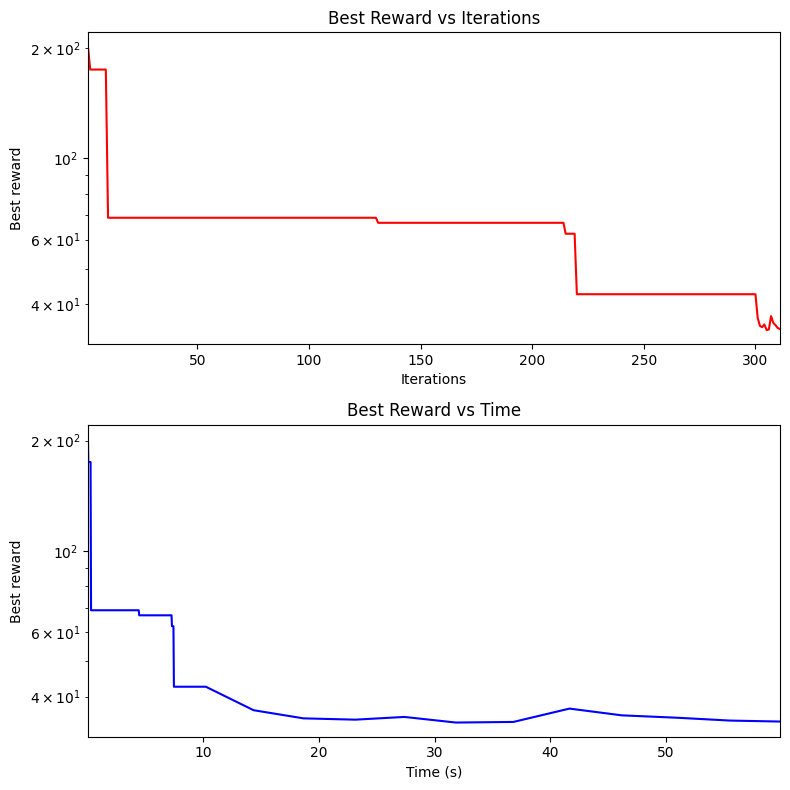

In [ ]:
# plot_training(data_res, e_tot)
performance_plots(e_tot, time_axis, gbest_history, multiruns=False)

Code for determining average rewards and standard deviations:

In [47]:
# Stability analysis

def reward_stability(algorithm, no_runs, t, time_reps):
    rewards = []
    # times = []
    # gbests = np.zeros((iterations+1, no_runs))
    # time_matrix = np.zeros((iterations+1,))

    # Define the algorithm to be used
    
    def aux_algorithm(algorithm, iterations):
        if algorithm == ParticleSwarm:
            best_policy, best_reward, gbest_history, time_axis = ParticleSwarm(lower_bound=-1, upper_bound=1, no_particles=round(50), inertia=0.6, cognitive=0.2, social=0.2, regime=None, tmax=iterations)
        elif algorithm == GeneticSearch:
            best_policy, best_reward, gbest_history, time_axis = GeneticSearch(lower_bound=-1, upper_bound=1, mutation_rate=0.3, iterations=iterations, sample_size=50)
        elif algorithm == Generalized_policy_search:
            best_policy, best_reward, gbest_history, time_axis = Generalized_policy_search(shrink_ratio=0.9, radius=0.208, evals_shrink=iterations/30, evals=iterations+1, ratio_ls_rs=0.388)
        elif algorithm == Random_PSO_search:
            best_policy, best_reward, gbest_history, time_axis = Random_PSO_search(lower_bound=-2, upper_bound=2, iterations=iterations, ratio_rs_pso=0.3, no_particles=50, inertia=0.6, cognitive=0.2, social=0.2, gbest_limit=5)
        elif algorithm == Random_Genetic_search:
            best_policy, best_reward, gbest_history, time_axis = Random_Genetic_search(lower_bound=-1, upper_bound=1, iterations=iterations, ratio_rs_genetic=0.32, sample_size=50, mutation_rate=0.22, radius=0.3)
        else:
            print("Invalid algorithm")
        return best_reward, gbest_history, time_axis
        
    # Time the algorithm
    start = time.time()
    best_reward, gbest_history, time_axis = aux_algorithm(algorithm, time_reps)
    stop = time.time()
    iteration_time = (stop - start)/(time_reps)
    no_iterations = round(t/iteration_time)

    rewards = []
    # times = []
    # Run the algorithm multiple times
    for i in range(no_runs):
        print("Run", i)
        best_reward, gbest_history, time_axis = aux_algorithm(algorithm, no_iterations)
        # gbest_time = time_axis[gbest_history.index(best_reward)]
        rewards.append(best_reward)
        # times.append(gbest_time)
        # gbests[:, i] = np.array(gbest_history)

    # Calculate average reward
    avg_reward = np.mean(rewards)
    std_reward = np.std(rewards)
        
    # Plot a histogram of the rewards with the mean and standard deviation
    # plt.hist(rewards, bins = no_bin, edgecolor = 'black')
    # performance_plots(50, time_matrix, gbests, multiruns=True)
    # plt.xlabel('Reward')
    # plt.ylabel('Frequency')
    # plt.title('Stability of the reward')
    # plt.show()
    print("Average reward:", avg_reward)
    print("Standard deviation:", std_reward)
    print("iteration time:", iteration_time)
    print("no_iterations:", no_iterations)
        

    
    return rewards, avg_reward, std_reward, iteration_time, no_iterations

In [48]:
# Multistage Extraction Results table

# Initialise data
number_of_runs = 10 # 10 as default
test_time = 300 # seconds, 30 as default
algorithms = [Generalized_policy_search] # [ParticleSwarm, GeneticSearch, Generalized_policy_search, Random_PSO_search, Random_Genetic_search]
results = {}

for algorithm in algorithms:
    print(algorithm)
    if algorithm == Generalized_policy_search:
        n = 5000
    else:
        n = 100
    rewards, avg_reward, std_reward, iteration_time, no_iterations = reward_stability(algorithm=algorithm, no_runs=number_of_runs, t=test_time, time_reps=n)
    results[algorithm] = [avg_reward, std_reward, iteration_time, no_iterations]

# Print results
print('reward_stability', rewards)
print("Algorithm", " | ","Average reward", " | ", "Standard deviation", " | ", "Iteration time", " | ", "No. iterations")
for algorithm in algorithms:
    print(algorithm, " | ", results[algorithm][0], " | ", results[algorithm][1], " | ", results[algorithm][2], " | ", results[algorithm][3])

<function Generalized_policy_search at 0x17e449760>
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700
Iteration 1800
Iteration 1900
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700
Iteration 1800
Iteration 1900
Iteration 2000
Iteration 2100
Iteration 2200
Iteration 2300
Iteration 2400
Iteration 2500
Iteration 2600
Iteration 2700
Iteration 2800
Iteration 2900
Iteration 3000
final reward =  6.256297471010265
radius =  0.08953717968000002
time =  196.13510489463806
Run 0
Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700


Performance of trained algorithms:

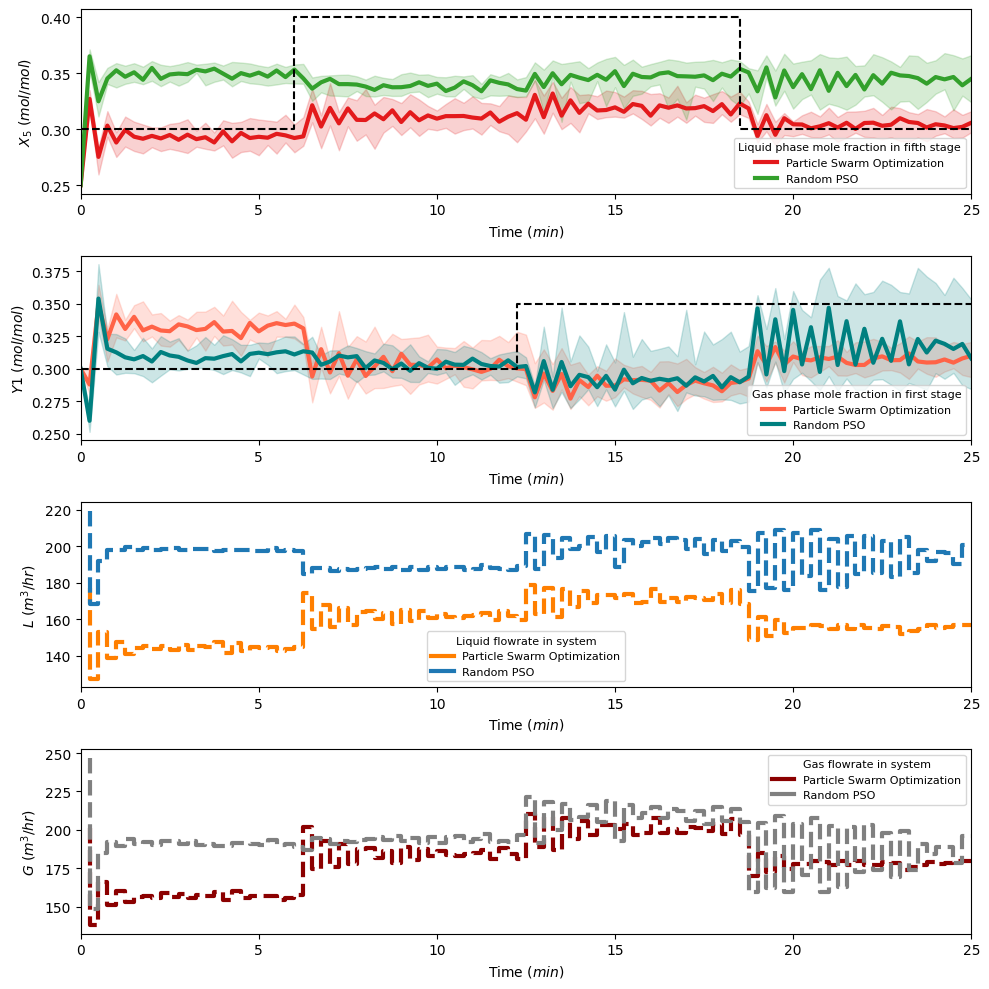

In [40]:
nx            = 2
nu            = 2
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
policy_net_SPS_RL = Net(**hyparams, requires_grad=True, retain_graph=True)
policy_net_SPS_RL.load_state_dict(best_policy)

reps = 10

# X1_eval = np.zeros((data_res['X1_dat'].shape[0], reps))
# X2_eval = np.zeros((data_res['X2_dat'].shape[0], reps))
# X3_eval = np.zeros((data_res['X3_dat'].shape[0], reps))
# X4_eval = np.zeros((data_res['X4_dat'].shape[0], reps))
X5_eval = np.zeros((data_res['X5_dat'].shape[0], reps))

Y1_eval = np.zeros((data_res['Y1_dat'].shape[0], reps))
# Y2_eval = np.zeros((data_res['Y2_dat'].shape[0], reps))
# Y3_eval = np.zeros((data_res['Y3_dat'].shape[0], reps))
# Y4_eval = np.zeros((data_res['Y4_dat'].shape[0], reps))
# Y5_eval = np.zeros((data_res['Y5_dat'].shape[0], reps))

L_eval = np.zeros((data_res['L_dat'].shape[0], reps))
G_eval = np.zeros((data_res['G_dat'].shape[0], reps))

for r_i in range(reps):
  X5_eval[:,r_i], Y1_eval[:,r_i], L_eval[:,r_i], G_eval[:,r_i] = J_PolicyDIST(policy_net_SPS_RL,
                                                               policy_alg='SPS_RL', 
                                                                collect_training_data=False, 
                                                                traj=True) 



nx            = 2
nu            = 2
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
policy_net_SPS_RL = Net(**hyparams, requires_grad=True, retain_graph=True)
policy_net_SPS_RL.load_state_dict(best_policy2)

X5_eval2 = np.zeros((data_res['X5_dat'].shape[0], reps))
Y1_eval2 = np.zeros((data_res['Y1_dat'].shape[0], reps))
L_eval2 = np.zeros((data_res['L_dat'].shape[0], reps))
G_eval2 = np.zeros((data_res['G_dat'].shape[0], reps))

for r_i in range(reps):
  X5_eval2[:,r_i], Y1_eval2[:,r_i], L_eval2[:,r_i], G_eval2[:,r_i] = J_PolicyDIST(policy_net_SPS_RL,
                                                               policy_alg='SPS_RL', 
                                                                collect_training_data=False, 
                                                                traj=True)

# , X1_eval[:,r_i], X2_eval[:,r_i], X3_eval[:,r_i], X4_eval[:,r_i], Y2_eval[:,r_i], Y3_eval[:,r_i], Y4_eval[:,r_i], Y5_eval[:,r_i]
  
# Plot the results
plot_simulation(X5_eval, Y1_eval, L_eval, G_eval, X5_eval2, Y1_eval2, L_eval2, G_eval2, data_res)

# X1_eval, X2_eval, X3_eval, X4_eval, Y2_eval, Y3_eval, Y4_eval, Y5_eval,

Separating plotting into two parts to compare GPS w/o and with BO

In [106]:
nx            = 2
nu            = 2
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
policy_net_SPS_RL = Net(**hyparams, requires_grad=True, retain_graph=True)
policy_net_SPS_RL.load_state_dict(best_policy)

reps = 10

# X1_eval = np.zeros((data_res['X1_dat'].shape[0], reps))
# X2_eval = np.zeros((data_res['X2_dat'].shape[0], reps))
# X3_eval = np.zeros((data_res['X3_dat'].shape[0], reps))
# X4_eval = np.zeros((data_res['X4_dat'].shape[0], reps))
X5_eval = np.zeros((data_res['X5_dat'].shape[0], reps))

Y1_eval = np.zeros((data_res['Y1_dat'].shape[0], reps))
# Y2_eval = np.zeros((data_res['Y2_dat'].shape[0], reps))
# Y3_eval = np.zeros((data_res['Y3_dat'].shape[0], reps))
# Y4_eval = np.zeros((data_res['Y4_dat'].shape[0], reps))
# Y5_eval = np.zeros((data_res['Y5_dat'].shape[0], reps))

L_eval = np.zeros((data_res['L_dat'].shape[0], reps))
G_eval = np.zeros((data_res['G_dat'].shape[0], reps))

for r_i in range(reps):
  X5_eval[:,r_i], Y1_eval[:,r_i], L_eval[:,r_i], G_eval[:,r_i] = J_PolicyDIST(policy_net_SPS_RL,
                                                               policy_alg='SPS_RL', 
                                                                collect_training_data=False, 
                                                                traj=True) 



In [63]:

reps = 10

nx            = 2
nu            = 2
hyparams      = {'input_size': nx+2, 'output_size': nu} # include setpoints +2
policy_net_SPS_RL = Net(**hyparams, requires_grad=True, retain_graph=True)
policy_net_SPS_RL.load_state_dict(best_policy2)

X5_eval2 = np.zeros((data_res['X5_dat'].shape[0], reps))
Y1_eval2 = np.zeros((data_res['Y1_dat'].shape[0], reps))
L_eval2 = np.zeros((data_res['L_dat'].shape[0], reps))
G_eval2 = np.zeros((data_res['G_dat'].shape[0], reps))

for r_i in range(reps):
  X5_eval2[:,r_i], Y1_eval2[:,r_i], L_eval2[:,r_i], G_eval2[:,r_i] = J_PolicyDIST(policy_net_SPS_RL,
                                                               policy_alg='SPS_RL', 
                                                                collect_training_data=False, 
                                                                traj=True)


best reward w/o BO 16.0257863617835 best reward w BO 7.357958139617011


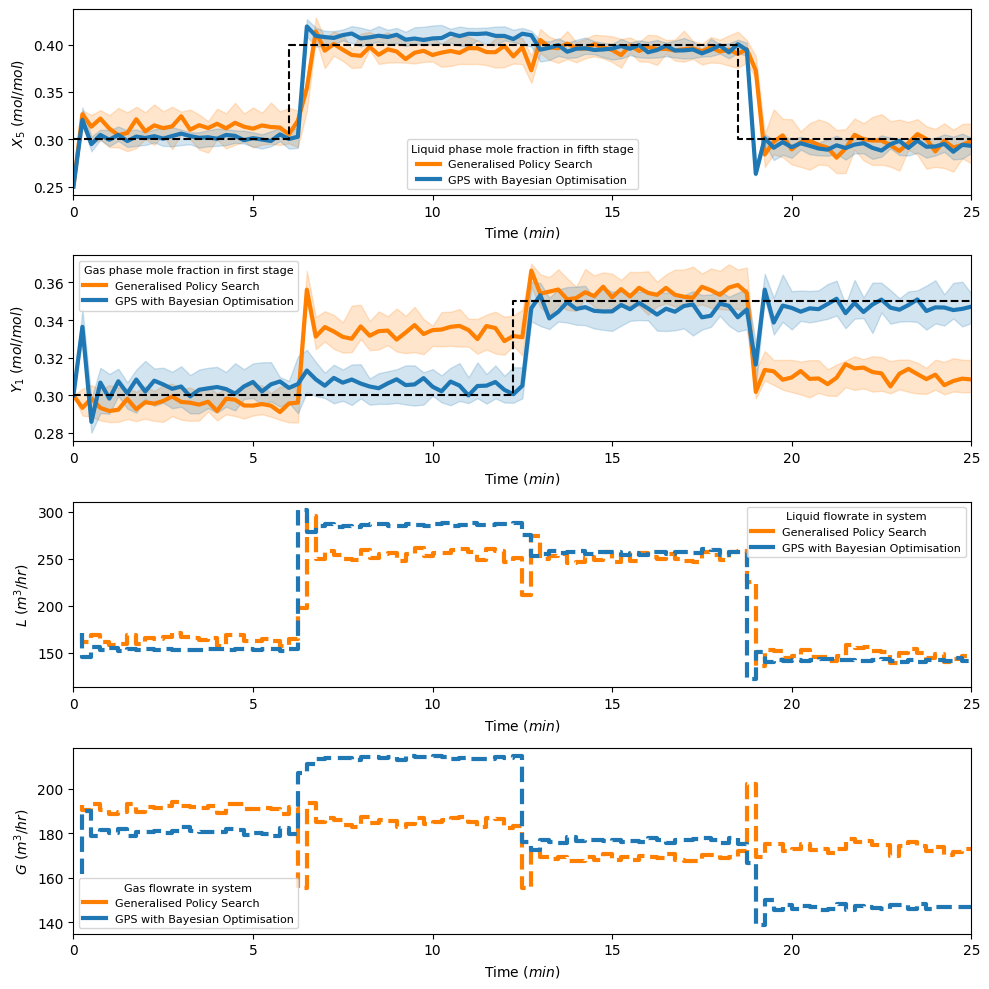

In [107]:
print('best reward w/o BO', best_reward, 'best reward w BO', best_reward2)
plot_simulation(X5_eval, Y1_eval, L_eval, G_eval, X5_eval2, Y1_eval2, L_eval2, G_eval2, data_res)